In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# define directory paths to reference later

train_dir = '/kaggle/input/vesuvius-challenge-ink-detection/train/'
test_dir = '/kaggle/input/vesuvius-challenge-ink-detection/test/'

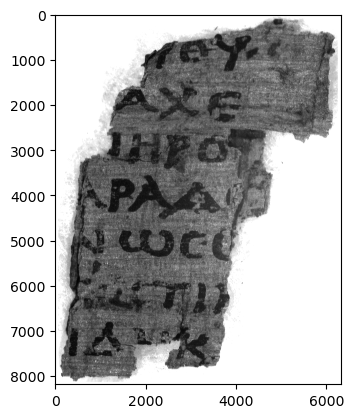

In [3]:
# plot the first fragment infrared scan

import matplotlib.pyplot as plt
import PIL.Image as Image

plt.imshow(Image.open(train_dir + '1/ir.png'), cmap='gray')

In [4]:
# import libraries, define device type

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

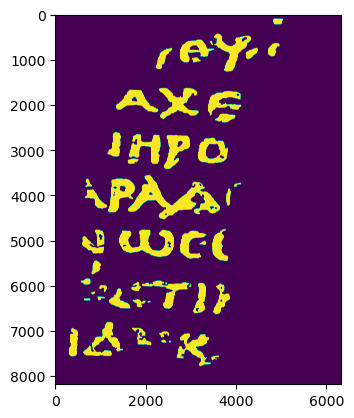

In [5]:
# example plot for the labels of the first fragment
label = np.array(Image.open(train_dir+"/1/inklabels.png"))
plt.imshow(label)

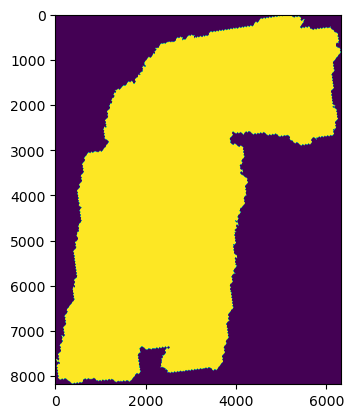

In [6]:
# only some pixels contain useful data - the mask contains the indices of these pixels
# plot these pixels for the first fragment
mask = Image.open(train_dir + '1/mask.png')
mask = np.array(mask)
plt.imshow(mask)

In [7]:
def get_indices(full_img, size=224):
    """
    full_img - numpy array, should be the mask of useful pixels for a particular fragment
    size - int, desired input size for the model
    
    baseline approach - given an input size, reduce a full scan into non-overlapping
    subscans of the desired size.  Discards any extra pixels, discards any subscan 
    without at least one useful pixel.  
    
    Using this method, returns a list of indices of 
    the form (i, j) which can be used to slice a full scan by taking size*i:size*(i+1)
    and size*j:size*(j+1) respectively. 
    """
    lenx, leny = full_img.shape[0], full_img.shape[1]
    indices = []
    for i in range(lenx // 224):
        for j in range(leny // 224):
            img = full_img[224*i:224*(i+1), 224*j:224*(j+1)]
            if img.sum() > 0:
                indices.append((i, j))
    return indices

In [8]:
def load_images(fragment_id, z_start, z_dim, train=True):
    """
    fragment_id - string, desired fragment to load
    z_start - int, specifies starting point for loading scans
    z_dim - int, number of scans to load from z_start

    Returns a list of scans starting from z=z_start to z=z_dim for a particular fragment_id
    """
        
    if train:
        path = train_dir + f'/{fragment_id}/surface_volume/*.tif'
    else:
        path = test_dir + f'/{fragment_id}/surface_volume/*.tif'
    images = [np.array(Image.open(filename), dtype=np.float32)/65535.0 for filename \
          in tqdm(sorted(glob.glob(path))[z_start:z_start+z_dim])]
    return images

In [9]:
class VesuviusDATASET(data.Dataset):
    def __init__(self, fragment_ids, indices, z_start, z_dim, size=224, train=True):
        self.size = size
        self.image_indices = []
        self.labels = []
        
        for fragment_id in fragment_ids:
            for scan_no in range(len(fragment_scans[fragment_id])):
                self.image_indices.extend([x for x in indices])
            self.labels.extend([(fragment_id, x) for x in indices])

    def __getitem__(self, index):
        fragment_id, scan_no, (i, j) = self.image_indices[index]
        
        image = fragment_scans[fragment_id][scan_no]
        image = image[self.size*i:self.size*(i+1), self.size*j:self.size*(j+1)]
        
        label = fragment_labels[fragment_id]
        label = label[self.size*i:self.size*(i+1), self.size*j:self.size*(j+1)]

        return image, label
    
    def __len__(self):
        return len(self.image_indices)

In [10]:
from tqdm import tqdm
import glob

In [11]:
fragment_ids = ['1']
fragment_scans, fragment_labels = {}, {}
indices = []
z_start = 20
z_dim = 20

# not implemented yet - for future validation split
# fragment_image_indexes = []
for fragment_id in fragment_ids:
    path = train_dir + f'/{fragment_id}/'
    fragment_labels[fragment_id] = np.array(Image.open(path+"inklabels.png"))
    fragment_scans[fragment_id] = load_images(fragment_id, z_start, z_dim)
    mask = Image.open(path + 'mask.png')
    mask = np.array(mask)
    fragment_indices = get_indices(mask)
    for scan_no in range(len(fragment_scans[fragment_id])):
        idx = [[fragment_id, scan_no, x] for x in fragment_indices]
        indices.extend(idx)
        
        # not implemented yet - for future validation split 
        # fragment_image_indexes.append(len(idx))

# baseline approach: use 80% data for train, rest for validation
# in futute: better to a withheld fragment for validation as it 
# is a better reflection of the test set and the task 
train_indices = indices[:int(len(indices)*.8)]
valid_indices = indices[int(len(indices)*.8):]


train_dataset = VesuviusDATASET(fragment_ids, train_indices, z_start, z_dim)
valid_dataset = VesuviusDATASET(fragment_ids, valid_indices, z_start, z_dim)

train_dataloader = data.DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_dataloader = data.DataLoader(valid_dataset, batch_size=64, shuffle=True)

100%|██████████| 20/20 [00:30<00:00,  1.53s/it]


In [12]:
images, labels = next(iter(train_dataloader))
images, labels = images[:4], labels[:4]

In [13]:
len(list(zip(images, labels)))

4

<Figure size 1200x1200 with 0 Axes>

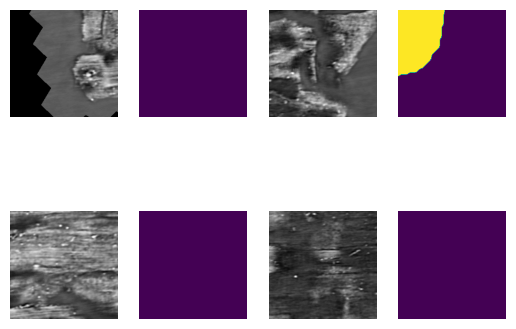

In [14]:
plt.figure(figsize=(12, 12))

fig, ax = plt.subplots(2, 4)
for i, (image, label) in enumerate(zip(images, labels)):
    if i < 2:
        ax[0][2*i].imshow(image, cmap='gray')
        ax[0][2*i+1].imshow(label)
        ax[0][2*i].axis('off'), ax[0][2*i+1].axis('off')
    else:
        i -= 2
        ax[1][2*i].imshow(image, cmap='gray')
        ax[1][2*i+1].imshow(label)
        ax[1][2*i].axis('off'), ax[1][2*i+1].axis('off')